# Figure. X Inactivation

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import scipy.stats as stats 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sms

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    pbt.set_tempdir('/frazer01/home/cdeboever/tmp')
    
outdir = os.path.join(ciepy.root, 'output',
                      'figure_x_inactivation')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'figure_x_inactivation')
cpy.makedir(private_outdir)

In [2]:
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 8

In [3]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

genes = pbt.BedTool(cpy.gencode_gene_bed)

fn = os.path.join(ciepy.root, 'output', 'input_data', 'cnvs.tsv')
cnvs = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'x_inactivation', 'x_ase_exp.tsv')
x_exp = pd.read_table(fn, index_col=0)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_p = pd.Panel(snv_res)

In [5]:
# We'll keep female subjects with no CNVs on the X chromosome.
sf = subject_meta[subject_meta.sex == 'F']
meta = sf.merge(rna_meta, left_index=True, right_on='subject_id')
s = set(meta.subject_id) & set(cnvs.ix[cnvs.chr == 'chrX', 'subject_id'])
meta = meta[meta.subject_id.apply(lambda x: x not in s)]

meta = meta.ix[[x for x in snv_p.items if x in meta.index]]

snv_p = snv_p.ix[meta.index]

In [6]:
snv_p = snv_p.ix[meta.index]
locus_p = locus_p.ix[meta.index]

In [7]:
# Filter and take log.
tpm_f = tpm[meta[meta.sex == 'F'].index]
tpm_f = tpm_f[(tpm_f != 0).sum(axis=1) > 0]
log_tpm = np.log10(tpm_f + 1)
# Mean center.
log_tpm_c = (log_tpm.T - log_tpm.mean(axis=1)).T
# Variance normalize.
log_tpm_n = (log_tpm_c.T / log_tpm_c.std(axis=1)).T

In [8]:
single = locus_p.ix['071ca248-bcb1-484d-bff2-3aefc84f8688', :, :].dropna()
x_single = single[gene_info.ix[single.index, 'chrom'] == 'chrX']
notx_single = single[gene_info.ix[single.index, 'chrom'] != 'chrX']

In [9]:
t = locus_p.ix[:, :, 'major_allele_freq']
x_all = locus_p.ix[:, set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index), :]
notx_all = locus_p.ix[:, set(t.index) & set(gene_info[gene_info.chrom != 'chrX'].index), :]

In [10]:
genes_to_plot = ['XIST', 'TSIX']
t = pd.Series(gene_info.index, index=gene_info.gene_name)
    
exp = log_tpm_n.ix[t[genes_to_plot]].T
exp.columns = genes_to_plot
exp = exp.ix[x_all.items].sort_values(by='XIST', ascending=False)

In [11]:
sns.set_style('white')

## Paper

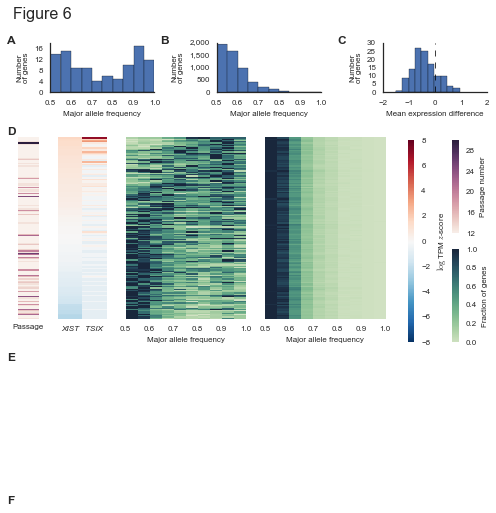

In [47]:
fig = plt.figure(figsize=(6.85, 9), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure 6',
        size=16, va='top', )
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.90, 0.5, 1])

gs = gridspec.GridSpec(1, 3)
ax = fig.add_subplot(gs[0, 0])
ax.hist(x_single.major_allele_freq, bins=np.arange(0.5, 1.05, 0.05))
ax.set_xlim(0.5, 1)
ax.set_ylabel('Number\nof genes', fontsize=8)
ax.set_xlabel('Major allele frequency', fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks(np.arange(0, 20, 4))
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)

ax = fig.add_subplot(gs[0, 1])
ax.hist(notx_single.major_allele_freq, bins=np.arange(0.5, 1.05, 0.05))
ax.set_xlim(0.5, 1)
ax.set_ylabel('Number\nof genes', fontsize=8)
ax.set_xlabel('Major allele frequency', fontsize=8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)

ax = fig.add_subplot(gs[0, 2])
ax.hist((x_exp.mean_sig_exp - x_exp.mean_not_sig_exp))
ax.set_ylabel('Number\nof genes', fontsize=8)
ax.set_xlabel('Mean expression difference', fontsize=8)
xmin, xmax = ax.get_xlim()
ax.set_xlim(-max(abs(xmin), abs(xmax)), max(abs(xmin), abs(xmax)))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
ax.set_xticks([-2, -1, 0, 1, 2])
ymin, ymax = ax.get_ylim()
ax.vlines(0, ymin, ymax, linestyle='--', lw=0.75);
ax2 = ax
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)

gs.tight_layout(fig, rect=[0, 0.8, 1, 0.95])

gs = gridspec.GridSpec(1, 4, width_ratios=[0.5, 1.2, 3, 3])

ax = fig.add_subplot(gs[0, 0])
passage_im = ax.imshow(np.array([meta.ix[exp.index, 'passage'].values]).T,
                       aspect='auto', interpolation='nearest',
                       cmap=sns.palettes.cubehelix_palette(light=.95, as_cmap=True))
ciepy.clean_axis(ax)
ax.set_xlabel('Passage', fontsize=8)

ax = fig.add_subplot(gs[0, 1])

# Make norm.
vmin = np.floor(exp.min().min())
vmax = np.ceil(exp.max().max())
vmax = max([vmax, abs(vmin)])
vmin = vmax * -1
exp_norm = mpl.colors.Normalize(vmin, vmax)

exp_im = ax.imshow(exp, aspect='auto', interpolation='nearest',
                   norm=exp_norm, cmap=plt.get_cmap('RdBu_r'))
ciepy.clean_axis(ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(exp.columns, fontsize=8)
for t in ax.get_xticklabels():
    t.set_fontstyle('italic') 
    #t.set_rotation(30)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
    
percent_norm = mpl.colors.Normalize(0, 1)

ax = fig.add_subplot(gs[0, 2])
r = x_all.ix[:, :, 'major_allele_freq'].apply(lambda z: pd.cut(z[z.isnull() == False], 
                                                       bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
r = (r.T / r.max(axis=1)).T
x_ase_im = ax.imshow(r.ix[exp.index], aspect='auto', interpolation='nearest',
                     norm=percent_norm, cmap=sns.palettes.cubehelix_palette(start=0, rot=-0.5, as_cmap=True))
ciepy.clean_axis(ax)
xmin,xmax = ax.get_xlim()
ax.set_xticks(np.arange(xmin, xmax + 1, 2))
ax.set_xticklabels(np.arange(0.5, 1.05, 0.1), fontsize=8)#, rotation=30)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
ax.set_xlabel('Major allele frequency', fontsize=8)
    
ax = fig.add_subplot(gs[0, 3])
r = notx_all.ix[:, :, 'major_allele_freq'].apply(lambda z: pd.cut(z[z.isnull() == False], 
                                                                   bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
r = (r.T / r.max(axis=1)).T
not_x_ase_im = ax.imshow(r.ix[exp.index], aspect='auto', interpolation='nearest',
                         norm=percent_norm, cmap=sns.palettes.cubehelix_palette(start=0, rot=-0.5, as_cmap=True))
ciepy.clean_axis(ax)
xmin,xmax = ax.get_xlim()
ax.set_xticks(np.arange(xmin, xmax + 1, 2))
ax.set_xticklabels(np.arange(0.5, 1.05, 0.1), fontsize=8)#, rotation=30)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
ax.set_xlabel('Major allele frequency', fontsize=8)

gs.tight_layout(fig, rect=[0, 0.45, 0.8, 0.8])

gs = gridspec.GridSpec(2, 2)

# Plot colormap for gene expression.
ax = fig.add_subplot(gs[0:2, 0])
cb = plt.colorbar(mappable=exp_im, cax=ax)
cb.solids.set_edgecolor("face")
cb.outline.set_linewidth(0)
for l in ax.get_yticklines():
    l.set_markersize(0)
cb.set_label('$\log$ TPM $z$-score', fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)

# Plot colormap for passage number.
ax = fig.add_subplot(gs[0, 1])
cb = plt.colorbar(mappable=passage_im, cax=ax)
cb.solids.set_edgecolor("face")
cb.outline.set_linewidth(0)
for l in ax.get_yticklines():
    l.set_markersize(0)
cb.set_label('Passage number', fontsize=8)
cb.set_ticks(np.arange(12, 32, 4))
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)

# Plot colormap for ASE.
ax = fig.add_subplot(gs[1, 1])
cb = plt.colorbar(mappable=x_ase_im, cax=ax)
cb.solids.set_edgecolor("face")
cb.outline.set_linewidth(0)
for l in ax.get_yticklines():
    l.set_markersize(0)
cb.set_label('Fraction of genes', fontsize=8)
cb.set_ticks(np.arange(0, 1.2, 0.2))
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)

gs.tight_layout(fig, rect=[0.8, 0.45, 1, 0.8])

t = fig.text(0.005, 0.93, 'A', weight='bold', 
             size=12)
t = fig.text(0.315, 0.93, 'B', weight='bold', 
             size=12)
t = fig.text(0.675, 0.93, 'C', weight='bold', 
             size=12)
t = fig.text(0.005, 0.79, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.44, 'E', weight='bold', 
             size=12)
t = fig.text(0.005, 0.22, 'F', weight='bold', 
             size=12)

plt.savefig(os.path.join(outdir, 'x_inactivation_skeleton.pdf'))

In [13]:
%%R

suppressPackageStartupMessages(library(Gviz))

In [26]:
t = x_all.ix[:, :, 'major_allele_freq']
r = gene_info.ix[t.index, ['start', 'end']]

In [27]:
%%R -i t,r

ideoTrack <- IdeogramTrack(genome = "hg19", chromosome = "chrX", fontsize=8, fontsize.legend=8,
                           fontcolor='black', cex=1, cex.id=1, cex.axis=1, cex.title=1)

mafTrack <- DataTrack(range=r, data=t, genome="hg19", type=c("p"), alpha=0.5, lwd=8,
                      span=0.05, chromosome="chrX", name="Major allele frequency", fontsize=8,
                      fontcolor.legend='black', col.axis='black', col.title='black',
                      background.title='transparent', cex=1, cex.id=1, cex.axis=1, cex.title=1,
                      fontface=1, fontface.title=1, alpha.title=1)

In [28]:
fn = os.path.join(outdir, 'p_maf.pdf')

In [29]:
%%R -i fn

pdf(fn, 6.85, 2)
plotTracks(c(ideoTrack, mafTrack), from=0, to=58100000, col.title='black')
dev.off()

png 
  2 


In [30]:
fn = os.path.join(outdir, 'q_maf.pdf')

In [31]:
%%R -i fn

pdf(fn, 6.85, 2)
plotTracks(c(ideoTrack, mafTrack), from=63000000, to=155270560)
dev.off()

png 
  2 


## Presentation

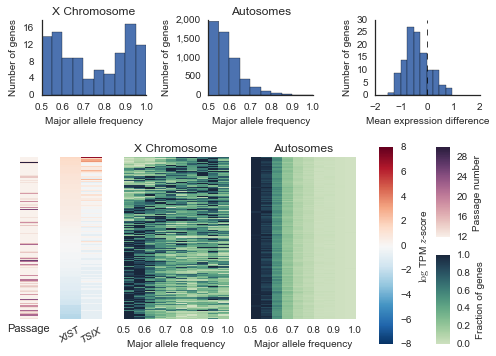

In [36]:
# Set fontsize
fs = 10

fig = plt.figure(figsize=(6.85, 5), dpi=300)

gs = gridspec.GridSpec(1, 3)
ax = fig.add_subplot(gs[0, 0])
ax.hist(x_single.major_allele_freq, bins=np.arange(0.5, 1.05, 0.05))
ax.set_xlim(0.5, 1)
ax.set_ylabel('Number of genes', fontsize=fs)
ax.set_xlabel('Major allele frequency', fontsize=fs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks(np.arange(0, 20, 4))
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
ax.set_title('X Chromosome')

ax = fig.add_subplot(gs[0, 1])
ax.hist(notx_single.major_allele_freq, bins=np.arange(0.5, 1.05, 0.05))
ax.set_xlim(0.5, 1)
ax.set_ylabel('Number of genes', fontsize=fs)
ax.set_xlabel('Major allele frequency', fontsize=fs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
ax.yaxis.set_major_formatter(ciepy.comma_format)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
ax.set_title('Autosomes')

ax = fig.add_subplot(gs[0, 2])
ax.hist((x_exp.mean_sig_exp - x_exp.mean_not_sig_exp))
ax.set_ylabel('Number of genes', fontsize=fs)
ax.set_xlabel('Mean expression difference', fontsize=fs)
xmin, xmax = ax.get_xlim()
ax.set_xlim(-max(abs(xmin), abs(xmax)), max(abs(xmin), abs(xmax)))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
ax.set_xticks([-2, -1, 0, 1, 2])
ymin, ymax = ax.get_ylim()
ax.vlines(0, ymin, ymax, linestyle='--', lw=0.75);
ax2 = ax
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)

gs.tight_layout(fig, rect=[0, 0.62, 1, 1.0])

# t = fig.text(0.005, 0.88, 'A', weight='bold', 
#              size=12)
# t = fig.text(0.315, 0.88, 'B', weight='bold', 
#              size=12)
# t = fig.text(0.675, 0.88, 'C', weight='bold', 
#              size=12)

gs = gridspec.GridSpec(1, 4, width_ratios=[0.5, 1.2, 3, 3])

ax = fig.add_subplot(gs[0, 0])
passage_im = ax.imshow(np.array([meta.ix[exp.index, 'passage'].values]).T,
                       aspect='auto', interpolation='nearest',
                       cmap=sns.palettes.cubehelix_palette(light=.95, as_cmap=True))
ciepy.clean_axis(ax)
ax.set_xlabel('Passage')

ax = fig.add_subplot(gs[0, 1])

# Make norm.
vmin = np.floor(exp.min().min())
vmax = np.ceil(exp.max().max())
vmax = max([vmax, abs(vmin)])
vmin = vmax * -1
exp_norm = mpl.colors.Normalize(vmin, vmax)

exp_im = ax.imshow(exp, aspect='auto', interpolation='nearest',
                   norm=exp_norm, cmap=plt.get_cmap('RdBu_r'))
ciepy.clean_axis(ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(exp.columns, fontsize=fs)
for t in ax.get_xticklabels():
    t.set_fontstyle('italic') 
    t.set_rotation(30)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
    
percent_norm = mpl.colors.Normalize(0, 1)

ax = fig.add_subplot(gs[0, 2])
r = x_all.ix[:, :, 'major_allele_freq'].apply(lambda z: pd.cut(z[z.isnull() == False], 
                                                       bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
r = (r.T / r.max(axis=1)).T
x_ase_im = ax.imshow(r.ix[exp.index], aspect='auto', interpolation='nearest',
                     norm=percent_norm, cmap=sns.palettes.cubehelix_palette(start=0, rot=-0.5, as_cmap=True))
ciepy.clean_axis(ax)
xmin,xmax = ax.get_xlim()
ax.set_xticks(np.arange(xmin, xmax + 1, 2))
ax.set_xticklabels(np.arange(0.5, 1.05, 0.1), fontsize=fs)#, rotation=30)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
ax.set_xlabel('Major allele frequency', fontsize=fs)
ax.set_title('X Chromosome')
    
ax = fig.add_subplot(gs[0, 3])
r = notx_all.ix[:, :, 'major_allele_freq'].apply(lambda z: pd.cut(z[z.isnull() == False], 
                                                                   bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
r = (r.T / r.max(axis=1)).T
not_x_ase_im = ax.imshow(r.ix[exp.index], aspect='auto', interpolation='nearest',
                         norm=percent_norm, cmap=sns.palettes.cubehelix_palette(start=0, rot=-0.5, as_cmap=True))
ciepy.clean_axis(ax)
xmin,xmax = ax.get_xlim()
ax.set_xticks(np.arange(xmin, xmax + 1, 2))
ax.set_xticklabels(np.arange(0.5, 1.05, 0.1), fontsize=fs)#, rotation=30)
for l in ax.get_xticklines() + ax.get_yticklines(): 
    l.set_markersize(0)
ax.set_xlabel('Major allele frequency', fontsize=fs)
ax.set_title('Autosomes')
    
# t = fig.text(0.005, 0.615, 'D', weight='bold', 
#              size=12)

gs.tight_layout(fig, rect=[0, 0, 0.75, 0.62])

gs = gridspec.GridSpec(2, 2)

# Plot colormap for gene expression.
ax = fig.add_subplot(gs[0:2, 0])
cb = plt.colorbar(mappable=exp_im, cax=ax)
cb.solids.set_edgecolor("face")
cb.outline.set_linewidth(0)
for l in ax.get_yticklines():
    l.set_markersize(0)
cb.set_label('$\log$ TPM $z$-score', fontsize=fs)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)

# Plot colormap for passage number.
ax = fig.add_subplot(gs[0, 1])
cb = plt.colorbar(mappable=passage_im, cax=ax)
cb.solids.set_edgecolor("face")
cb.outline.set_linewidth(0)
for l in ax.get_yticklines():
    l.set_markersize(0)
cb.set_label('Passage number', fontsize=fs)
cb.set_ticks(np.arange(12, 32, 4))
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)

# Plot colormap for ASE.
ax = fig.add_subplot(gs[1, 1])
cb = plt.colorbar(mappable=x_ase_im, cax=ax)
cb.solids.set_edgecolor("face")
cb.outline.set_linewidth(0)
for l in ax.get_yticklines():
    l.set_markersize(0)
cb.set_label('Fraction of genes', fontsize=fs)
cb.set_ticks(np.arange(0, 1.2, 0.2))
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)

gs.tight_layout(fig, rect=[0.75, 0, 1, 0.62])

plt.savefig(os.path.join(outdir, 'x_inactivation_hists_heatmaps_presentation.pdf'))

In [22]:
t = x_all.ix[:, :, 'major_allele_freq']
r = gene_info.ix[t.index, ['start', 'end']]

In [30]:
%%R -i t,r

ideoTrack <- IdeogramTrack(genome = "hg19", chromosome = "chrX", fontsize=16, fontsize.legend=16,
                           fontcolor='black', cex=1, cex.id=1, cex.axis=1, cex.title=1)

mafTrack <- DataTrack(range=r, data=t, genome="hg19", type=c("smooth", "p"), alpha=0.75, lwd=8,
                      span=0.05, chromosome="chrX", name="Major allele frequency", fontsize=12,
                      fontcolor.legend='black', col.axis='black', col.title='black',
                      background.title='transparent', cex=1, cex.id=1, cex.axis=1, cex.title=1,
                      fontface=1, fontface.title=1, alpha.title=1)

In [32]:
fn = os.path.join(outdir, 'p_maf_presentation.pdf')

In [33]:
%%R -i fn

pdf(fn, 10, 3)
plotTracks(c(ideoTrack, mafTrack), from=0, to=58100000, col.title='black')
dev.off()

png 
  2 


In [34]:
fn = os.path.join(outdir, 'q_maf_presentation.pdf')

In [35]:
%%R -i fn

pdf(fn, 10, 3)
plotTracks(c(ideoTrack, mafTrack), from=63000000, to=155270560)
dev.off()

png 
  2 
